In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics

# sklearn
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp


In [273]:
# Helper functions

# function to split training and test data
def splitTrainTest(df):
    x_data = df.drop('gt', axis=1)
    y_data = df['gt']
    data = train_test_split(x_data, y_data, test_size=0.20, 
                                                    random_state=101)
    return data

def modelScore(y_true, y_pred):
    acc = metrics.accuracy_score(y_true, y_pred)
    pre = metrics.precision_score(y_true, y_pred)
    rec = metrics.recall_score(y_true, y_pred)
    return [acc, pre, rec]

# function to draw different ROC-curve for different fpr and tpr
def drawROC(fpr, tpr, auc, param):    
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle='--')
    plt.plot(fpr, tpr, label= param+'(AUC = {0:0.2f})'
                   ''.format(auc))
    plt.legend(loc=4)
    return plt
        
# function to fit and evaluate the model for different parameters
def modelEvaluation(model, params, data):
    # Split the data into different training and test set
    X_train, X_test, y_train, y_test = data
    
    # Set the different parameters
    paramlist = []
    for param in params: 
        for val in params[param]:
            var = {}
            var[param] = val
            paramlist.append(var)
    maxauc = 0
    bestmodel = ""
    for param in paramlist:
        
        #Fit the model
        model.set_params(**param)
        model.fit(X_train, y_train)
        
        # Model prediction
        y_pred = model.predict(X_test)
        scores = metrics.classification_report(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[::, 1]
        
        # Find fpr, tpr and auc
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        
        # Find maximum AUC
        if (auc > maxauc):
            maxauc = auc 
            bestparam = param

        
        # Draw ROC curve
        plt = drawROC(fpr, tpr, auc, str(param)) 
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        title = type(model).__name__ + " ROC curve"
        plt.figtext(0.5, 0.01, title, wrap=True, horizontalalignment='center', fontsize=12)
    # print("Best Model: " + bestmodel)
    return (bestparam, plt)          


In [268]:
def modelComparision(models, data):
    # Split the data into different training and test set
    X_train, X_test, y_train, y_test = data
    
    maxauc = 0
    for model in models:
        modelName = type(model).__name__ 
        
        #Fit the model        
        model.fit(X_train, y_train)
        
        # Model prediction
        y_pred = model.predict(X_test)
        scores = metrics.classification_report(y_test, y_pred)
        y_pred_proba = model.predict_proba(X_test)[::, 1]
        
        # Find fpr, tpr and auc
        fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
        auc = metrics.roc_auc_score(y_test, y_pred_proba)
        
        # Find maximum AUC
        if (auc > maxauc):
            maxauc = auc 
            bestmodel = modelName
            bestscore = scores        

        
        # Draw ROC curve
        plt = drawROC(fpr, tpr, auc, modelName) 
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        title = "ROC Comparison"
        plt.figtext(0.5, 0.01, title, wrap=True, horizontalalignment='center', fontsize=12)
    print("Best Model: " + bestmodel)
    return (bestmodel, bestscore, plt)          


In [2]:
# Data url
phone_acc = "data/Phones_accelerometer.csv"
phone_gyro = "data/Phones_gyroscope.csv"
watch_acc = "data/Watch_accelerometer.csv"
watch_gyro = "data/Watch_gyroscope.csv"


# Read Data as string for all columns
df1 = pd.read_csv(phone_acc)
df2 = pd.read_csv(phone_gyro)
df3 = pd.read_csv(watch_acc)
df4 = pd.read_csv(watch_gyro)

In [65]:
# Data Merge 
drop_col = ["Index", "Arrival_Time", "Creation_Time", 'User', 'Model', 'Device']
new_df1 = df1.drop(drop_col, axis=1)
new_df2 = df2.drop(drop_col, axis=1, )
new_df3 = df3.drop(drop_col, axis=1)
new_df4 = df4.drop(drop_col, axis=1)
new_df1["sensor"] = "phone_acc"
new_df2["sensor"] = "phone_gyro"
new_df3["sensor"] = "watch_acc"
new_df4["sensor"] = "watch_gyro"

merged_df = pd.concat([new_df1, new_df2, new_df3, new_df4])

In [66]:
df_processed = merged_df.dropna()

In [209]:
df = df_processed
print("Processed Data Example: ")
print(df.head(10))

Processed Data Example: 
          x         y         z     gt     sensor
0 -5.958191  0.688065  8.135345  stand  phone_acc
1 -5.952240  0.670212  8.136536  stand  phone_acc
2 -5.995087  0.653549  8.204376  stand  phone_acc
3 -5.942718  0.676163  8.128204  stand  phone_acc
4 -5.991516  0.641647  8.135345  stand  phone_acc
5 -5.965332  0.629745  8.128204  stand  phone_acc
6 -5.991516  0.635696  8.162720  stand  phone_acc
7 -5.915344  0.630936  8.105591  stand  phone_acc
8 -5.984375  0.694016  8.067505  stand  phone_acc
9 -5.937958  0.715439  8.090118  stand  phone_acc


In [213]:
df = df.sample(100000, random_state = 11)

In [210]:
# Factorize all categorical/string columns 

# all numerical columns
num_col = ["x", "y", "z"]
# all string columns
str_col = [x for x in df.columns if (x not in num_col)]

for col in str_col:
    # Factorize the values 
    labels, levels = pd.factorize(df[col])
    # Save the encoded variables in `iris.Class`
    df[col] = labels


C:\Users\virus\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [171]:
# Check correlation among the features
corr = df[['x', 'y', 'z', 'sensor']].corr()
print(corr)

               x         y         z    sensor
x       1.000000 -0.007793 -0.194937  0.194164
y      -0.007793  1.000000  0.068009 -0.008793
z      -0.194937  0.068009  1.000000 -0.866913
sensor  0.194164 -0.008793 -0.866913  1.000000


In [77]:
# Cluster analysis for reduced class data

# Build the PCA model
pca = PCA(n_components=2)

# Reduce the data, output is ndarray
reduced_data = pca.fit_transform(df)
X_pca = reduced_data[:,0]
y_pca = reduced_data[:,1]

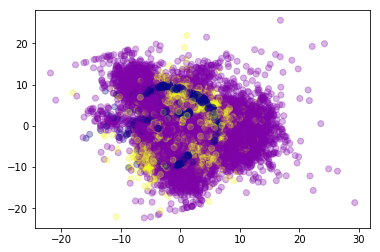

In [78]:
# Draw cluster
fig, ax = plt.subplots()
ax.scatter(X_pca, y_pca, c=df["gt"], cmap="plasma", alpha=0.3)
plt.show()

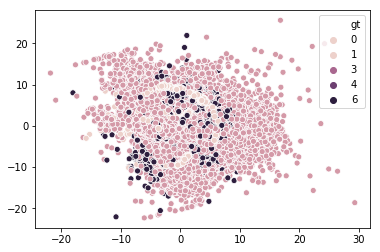

In [79]:
# Draw cluster using seaborn
sns.scatterplot(x=X_pca, y=y_pca, hue=df["gt"])
plt.show()

In [211]:
# Reduce the number of class. 
# Combine sitting and standing
df.loc[df['gt'] == 0, 'gt'] = 0
df.loc[df['gt'] == 1, 'gt'] = 0
# Combine walking and stair up and down
df.loc[df['gt'] == 2, 'gt'] = 1
df.loc[df['gt'] == 3, 'gt'] = 1
df.loc[df['gt'] == 4, 'gt'] = 1
df.loc[df['gt'] == 5, 'gt'] = 1

C:\Users\virus\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [190]:
df.head()

,x,y,z,gt,sensor
5635115,3.982239,-0.067703,9.492157,0,0
2913690,-2.548309,-1.117447,9.736145,0,0
9980021,-2.298405,0.919362,6.895215,1,0
137004,-7.989639,-5.521149,2.534287,0,1
2336510,-2.748544,1.589750,10.275913,1,0


In [173]:
# Cluster analysis for reduced class data

# Build the PCA model
pca = PCA(n_components=2)

# Reduce the data, output is ndarray
reduced_data = pca.fit_transform(df)
X_pca = reduced_data[:,0]
y_pca = reduced_data[:,1]

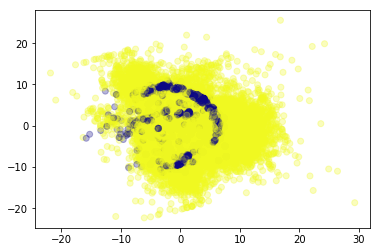

In [174]:
# Draw cluster
fig, ax = plt.subplots()
ax.scatter(X_pca, y_pca, c=df["gt"], cmap="plasma", alpha=0.3)
plt.show()

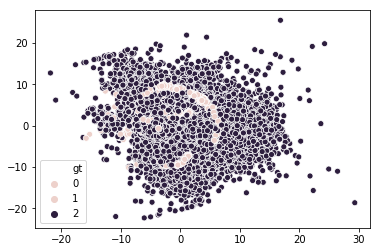

In [175]:
# Draw cluster using seaborn
sns.scatterplot(x=X_pca, y=y_pca, hue=df["gt"])
plt.show()

In [215]:
df['gt'].unique()

array([0, 1], dtype=int64)

In [219]:
df.head()

,x,y,z,gt,sensor
5635115,3.982239,-0.067703,9.492157,0,0
2913690,-2.548309,-1.117447,9.736145,0,0
9980021,-2.298405,0.919362,6.895215,1,0
137004,-7.989639,-5.521149,2.534287,0,2
2336510,-2.748544,1.589750,10.275913,1,0


In [220]:
# Splitting training and test data
X_train, X_test, y_train, y_test = splitTrainTest(df)

C:\Users\virus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\virus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\virus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


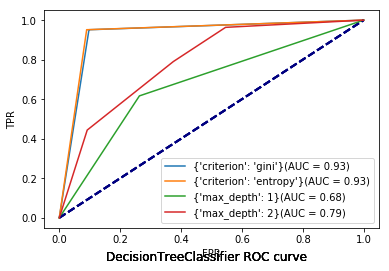

In [278]:
# fit Decision Tree model
from sklearn import tree
param = {"criterion": ["gini", "entropy"], "max_depth": [1, 2]}
treeparam, treeplt = modelEvaluation(tree.DecisionTreeClassifier(), dtparam, splitTrainTest(df))
treemodel = tree.DecisionTreeClassifier(**treeparam)
treemodel.fit(X_train,y_train)
treepred = treemodel.predict(X_test)
treescore = modelScore(y_test, treepred)


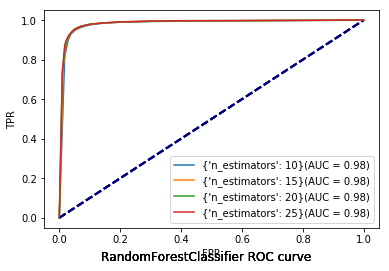

In [279]:
# Random Forest 
from sklearn.ensemble import RandomForestClassifier
param = {"n_estimators": [10, 15, 20, 25]}
rfparam, plt = modelEvaluation(RandomForestClassifier(), param, splitTrainTest(df))
rfmodel = RandomForestClassifier(**rfparam)
rfmodel.fit(X_train, y_train)
rfscore = modelScore(y_test, rfmodel.predict(X_test))

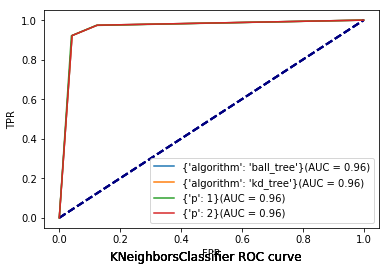

In [289]:
# K Nearest Neighbor
from sklearn.neighbors import KNeighborsClassifier
param = {"algorithm": ["ball_tree", "kd_tree"], "p": [1, 2]}
knnparam, plt = modelEvaluation(KNeighborsClassifier(2), param, splitTrainTest(df))
knnmodel = KNeighborsClassifier(**knnparam)
knnmodel.fit(X_train, y_train)
knnscore = modelScore(y_test, knnmodel.predict(X_test))

C:\Users\virus\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


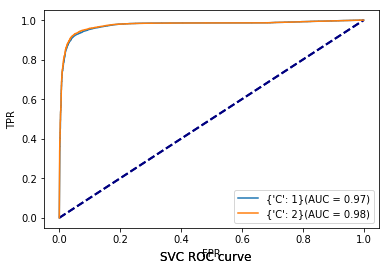

In [285]:
from sklearn.svm import SVC
df_svm = df.sample(10000, random_state=11)
X_train, X_test, y_train, y_test = splitTrainTest(df_svm)

param = {"C": [1, 2]}
svmparam, plt = modelEvaluation(SVC(probability=True, gamma='auto'), param, splitTrainTest(df))
svm = SVC(**svmparam)
svm.fit(X_train,y_train)
svmpred = svm.predict(X_test)
svmscore = modelScore(y_test, svmpred)

In [291]:
# Score table
indx = ["Accuracy", "Precision", "Recall"]
cols = ["DecisionTree", "RandomForest", "KNeighbors", "SVM"] 
score_df = pd.DataFrame(list(zip(treescore, rfscore, knnscore, svmscore)), indx, cols)
score_df

,DecisionTree,RandomForest,KNeighbors,SVM
Accuracy,0.922000,0.939500,0.928000,0.884500
Precision,0.944700,0.959199,0.965764,0.964807
Recall,0.936073,0.948250,0.923135,0.855403


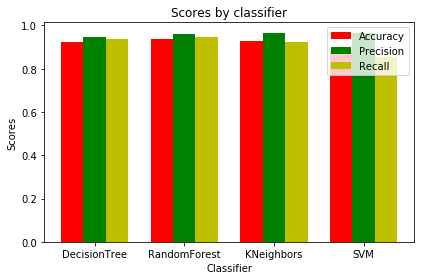

In [292]:
# Draw bargraph
n_classifiers = 4
accuracy = score_df.iloc[0,:]
precision = score_df.iloc[1,:]
recall = score_df.iloc[2,:]

fig, ax = plt.subplots()
idx = np.arange(n_classifiers)
bw = 0.25

plt.bar(idx, accuracy, bw, color='r', label='Accuracy')
plt.bar(idx+bw, precision, bw, color='g', label='Precision')
plt.bar(idx+bw+bw, recall, bw, color='y', label='Recall')


plt.xlabel('Classifier')
plt.ylabel('Scores')
plt.title('Scores by classifier')
plt.xticks(idx + bw, score_df.columns)
plt.legend()

plt.tight_layout()
plt.show()


Best Model: DecisionTreeClassifier with {'criterion': 'entropy'}


C:\Users\virus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\virus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\virus\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


("DecisionTreeClassifier with {'criterion': 'entropy'}",
 '              precision    recall  f1-score   support\n\n           0       0.90      0.91      0.91      6769\n           1       0.95      0.95      0.95     13231\n\n   micro avg       0.94      0.94      0.94     20000\n   macro avg       0.93      0.93      0.93     20000\nweighted avg       0.94      0.94      0.94     20000\n',
 <module 'matplotlib.pyplot' from 'C:\\Users\\virus\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>)

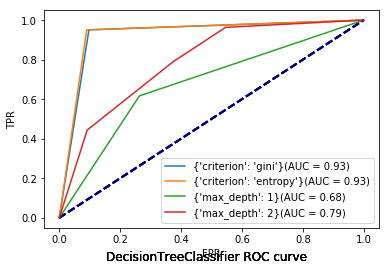

In [265]:
# ROC for different classifiers
dtparam = {"criterion": ["gini", "entropy"], "max_depth": [1, 2]}
modelEvaluation(treemodel, dtparam, splitTrainTest(df))

C:\Users\virus\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Best Model: RandomForestClassifier


('RandomForestClassifier',
 '              precision    recall  f1-score   support\n\n           0       0.93      0.93      0.93      6769\n           1       0.96      0.97      0.97     13231\n\n   micro avg       0.95      0.95      0.95     20000\n   macro avg       0.95      0.95      0.95     20000\nweighted avg       0.95      0.95      0.95     20000\n',
 <module 'matplotlib.pyplot' from 'C:\\Users\\virus\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>)

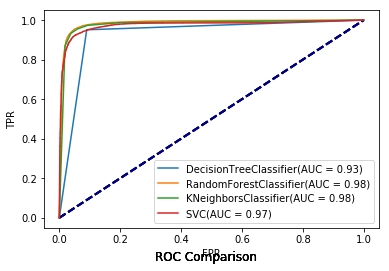

In [288]:
svm = SVC(probability=True)
mm = [treemodel, rfmodel, knnmodel, svm]
modelComparision(mm, splitTrainTest(df))